In [1]:
import numpy as np
import matplotlib.pyplot as plt

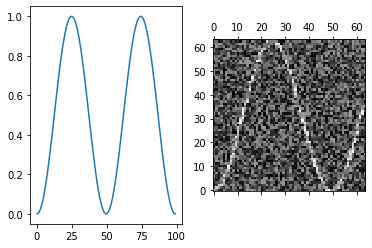

In [29]:
minmax = lambda x: (min(x), max(x))

def encode(series, n):
    plot = np.zeros((n,n))
    series = series[::len(series)//n][:n]
    series/=series.max()
    disc = (series*(n-1)).astype(int)
    for i in range(n):
        miny, maxy = minmax(disc[i:i+2])
        plot[miny:maxy+1,i]=1
    plot+=np.random.rand(plot.shape[0], plot.shape[1])*1.5
    return plot

x = np.sin(np.linspace(0, 2*np.pi, 100))**2
ax1, ax2 = plt.subplot(121), plt.subplot(122)
ax1.plot(x)
ax2.matshow(encode(x, 64), origin="lower", cmap="gray")

In [30]:
import pandas as pd
prices = pd.read_csv("/datasets/eur_usd/eurusd_minute.csv")['BidClose'].values
prices.shape

(5164235,)

/tmp/ipykernel_251/3614399171.py:6: RuntimeWarning: invalid value encountered in divide
  series/=series.max()


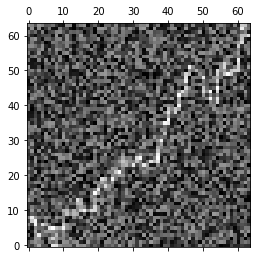

In [31]:
from torch.utils.data import Dataset
import torch

class PlotDataset(Dataset):
    def __init__(self, prices, n):
        values = np.array(prices)
        values = values[:len(values)//n*n]
        values = values.reshape(-1,n)
        values -= values.min(axis=1).reshape(-1,1)
        plots = np.zeros((len(prices)//n, n, n))
        for i in range(len(values)):
            plots[i]= encode(values[i], n)

        self.x = torch.from_numpy(plots).float().view(-1,1,n,n)


    def __len__(self):
        return self.x.size(0) 

    def __getitem__(self, idx):
        out = self.x[idx]
        return out

dataset = PlotDataset(prices, 64)
plt.matshow(dataset[0][0], origin="lower", cmap="gray")

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type=='cuda':
    !nvidia-smi

Sun Oct  2 16:28:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.05    Driver Version: 510.73.05    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 5000     Off  | 00000000:00:05.0 Off |                  Off |
| 33%   30C    P8     6W / 230W |   2456MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from src.models import Discriminator, Generator
from src.trainer import WGanGpTrainer
import torch.optim as optim
from torch.utils.data import DataLoader

d = Discriminator()
g = Generator()


trainer = WGanGpTrainer(
    generator=g,
    critic=d,
    gen_optimizer=optim.Adam(g.parameters(), lr=1e-4, betas=(0.0, 0.9)),
    critic_optimizer=optim.Adam(d.parameters(), lr=1e-4, betas=(0.0, 0.9)),
    latent_dimension=100,
    device=device,
    model_dir=None,
    write_dir="/storage/plot_experiment",
)

train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
trainer.train(train_loader, 100)

Training...


Epoch [1/100]:   5%|▌         | 136/2522 [00:07<01:59, 19.92it/s]